In [2]:
import matplotlib.pyplot as plt 
from CoolProp.CoolProp import PropsSI
import CoolProp.CoolProp as CP

import numpy as np
import pandas as pd


In [2]:
# atmospheric pressure
P_atm = 101325 / 1e5 # bar


Z_sf = -312 #seafloor depth [m]


# reservoir aquifer pressure
aq_P = 60 # bar
aq_P = 124

# reservoir reference depth
aq_Z = -1217 # mTVDMSL

# injection pointo r base of CO2 column
base_CO2_Z = -1312 # m

# base of cement plug/barrier
barrier_Z = -562

#density brine
rho_brine = 1024 # kg/m3

#gravity acceleration
G_acc = 9.8067 # m/s2

#Create depth vector
top = 0
base = 1500

z = -np.linspace(top, base, 1+(base-top))
df = pd.DataFrame(data={'depth':z})

fluid1 = 'CO2'
fluid2 = 'HEOS::CO2[0.96]&H2[0.004]&Ar[0.01]&N2[0.0084]&CH4[0.0178]'
fluid = 'CO2'

def P_aquifer(z, ref_Z, ref_P, rho = 1024, g = 9.8067):
    """
    Creates a hydrostatic gradient based on a given density that matches a reference pressure, depth point
    """

    P_offset = ref_P*1e5 + ref_Z*rho*g
    P = (-(z*g*rho) + P_offset) / 1e5
    return P

#Hydrostatic gradient



df['P_aq'] = P_aquifer(z=z, ref_P=aq_P, ref_Z=aq_Z)
df['P_hyd'] = P_atm-(df['depth']*rho_brine*G_acc)/1e5

df['Sh_min'] = df['P_hyd']
df.loc[df.depth<Z_sf, 'Sh_min'] = -(Z_sf*rho_brine*G_acc)/1e5 - 0.166*(df.loc[df.depth<Z_sf, 'depth']-Z_sf)

df


df.loc[df.depth>barrier_Z, 'P_aq'] =  df.loc[df.depth>barrier_Z, 'P_hyd']
df.loc[df.P_aq < P_atm, 'P_aq'] = 0

#Temperature
Tgrad = 40/1000 #thermal gradient [m/degC]
T_sf = 4 #seafloor temperature [degC]

df['Temp'] = T_sf - (df['depth']-Z_sf)*Tgrad #geothermal temperature field






# hydrostatic pressure at CO2 base
base_CO2_Phyd = P_aquifer(z=base_CO2_Z, ref_P=aq_P, ref_Z=aq_Z)

# hydrostatic pressure at barrier base
barrier_Phyd = P_aquifer(z=barrier_Z, ref_P=aq_P, ref_Z=aq_Z)

#vertical height between base of CO2 and base of barrier
col_CO2_height = barrier_Z - base_CO2_Z

# CO2 column
df['CO2_h'] = df['depth'] - base_CO2_Z
df.loc[(df['CO2_h']<0) | (df['CO2_h']>col_CO2_height), 'CO2_h'] = 0

# delta z
df['dz'] = df.depth.diff()

# create a column for P
df['P'] = df['P_aq']
df['P1'] = df['P_aq']
df['P2'] = df['P_aq']

# create a column for Pcap
df['dPcap'] = 0
df['Pcap'] = 0

df['dPcap1'] = 0
df['Pcap1'] = 0

df['dPcap2'] = 0
df['Pcap2'] = 0

df['rho_g'] = 0
df['rho_g1'] = 0
df['rho_g2'] = 0
df['phase'] = ''
df['phase1'] = ''
df['phase2'] = ''




query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')


for idx, row in query.iloc[::-1].iterrows():

    col_h  = row.CO2_h
    z = row.depth
    dz = row.dz
    T = row.Temp
    P_aq = row.P_aq

    if col_h == 0:
        P = P_aq
        P1 = P_aq
        P2 = P_aq
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)
        rho_g1 = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid1)
        rho_g2 = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid2)

        df.loc[idx, 'rho_g'] = rho_g
        df.loc[idx, 'rho_g1'] = rho_g1
        df.loc[idx, 'rho_g2'] = rho_g2
        Pcap = 0
        Pcap1 = 0
        Pcap2 = 0

        P_previous = P
        P_previous1 = P1
        P_previous2 = P2
        
    else:
        dPcap = -((rho_brine - rho_g)*dz*G_acc)/1e5
        dPcap1 = -((rho_brine - rho_g1)*dz*G_acc)/1e5
        dPcap2 = -((rho_brine - rho_g2)*dz*G_acc)/1e5


        Pcap += dPcap
        Pcap1 += dPcap1
        Pcap2 += dPcap2

        df.loc[idx, 'dPcap'] = dPcap
        df.loc[idx, 'Pcap'] = Pcap
        df.loc[idx, 'dPcap1'] = dPcap1
        df.loc[idx, 'Pcap1'] = Pcap1
        df.loc[idx, 'dPcap2'] = dPcap2
        df.loc[idx, 'Pcap2'] = Pcap2

        P = P_aq + Pcap
        P1 = P_aq + Pcap1
        P2 = P_aq + Pcap2


        df.loc[idx, 'P'] = P
        df.loc[idx, 'P1'] = P1
        df.loc[idx, 'P2'] = P2
        
        
        
        rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)
        rho_g1 = PropsSI("D", "P", P1*1e5, "T", T+273.15, fluid1)
        rho_g2 = PropsSI("D", "P", P2*1e5, "T", T+273.15, fluid2)

        # try:
        #     rho_g = PropsSI("D", "P", P*1e5, "T|gas", T+273.15, fluid)
        # except:
        #     rho_g = PropsSI("D", "P", P*1e5, "T", T+273.15, fluid)


        phase = CP.PhaseSI("P", P*1e5, "T", T+273.15, fluid)
        phase1 = CP.PhaseSI("P", P1*1e5, "T", T+273.15, fluid1)
        phase2 = CP.PhaseSI("P", P2*1e5, "T", T+273.15, fluid2)

        

        df.loc[idx, 'rho_g'] = rho_g
        df.loc[idx, 'rho_g1'] = rho_g1
        df.loc[idx, 'rho_g2'] = rho_g2

        df.loc[idx, 'phase'] = phase
        df.loc[idx, 'phase1'] = phase1
        df.loc[idx, 'phase2'] = phase2

        rho_previous = rho_g
        rho_previous1 = rho_g1
        rho_previous2 = rho_g2
        
            



133.46995671712875
133.39993535261112
133.32989366132483
133.25983163817276
133.18974927808293
133.11964657600862
133.0495235269281
132.9793801258449
132.90921636778748
132.83903224780954
132.76882776098972
132.69860290243176
132.62835766726445
132.5580920506415
132.4878060477417
132.41749965376872
132.34717286395124
132.2768256735428
132.20645807782185
132.13607007209177
132.06566165168076
131.99523281194172
131.92478354825263
131.854313856016
131.7838237306591
131.71331316763414
131.64278216241777
131.57223071051146
131.5016588074413
131.43106644875795
131.3604536300367
131.28982034687738
131.21916659490435
131.14849236976644
131.07779766713696
131.0070824827137
130.93634681221886
130.8655906513989
130.79481399602466
130.72401684189137
130.6531991848185
130.5823610206497
130.51150234525286
130.44062315452013
130.36972344436762
130.29880321073566
130.22786244958866
130.15690115691507
130.08591932872721
130.0149169610615
129.9438940499782
129.87285059156156
129.80178658191954
129.73070

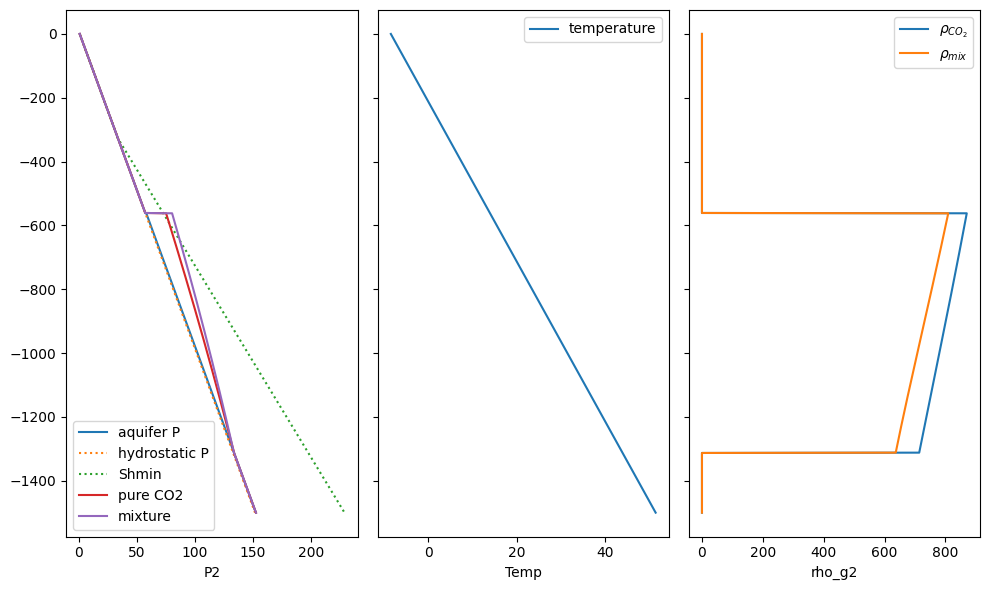

In [3]:



fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(10, 6))

df.plot(x='P_aq', y='depth', ax= ax1, label='aquifer P')
df.plot(x='P_hyd', y='depth', ax= ax1, label='hydrostatic P', linestyle=':')
df.plot(x='Sh_min', y='depth', ax= ax1, label='Shmin', linestyle=':')


# df.plot(x='P', y='depth', ax= ax1, label=fluid)
df.plot(x='P1', y='depth', ax= ax1, label='pure CO2')
df.plot(x='P2', y='depth', ax= ax1, label='mixture')
# ax1.plot(PFT['pressure'], -PFT['depth'], ls=':')

df.plot(x='Temp', y='depth', ax= ax2, label='temperature')
# df.plot(x='rho_g', y='depth', ax= ax3, label=r'$\rho_{CO_2}$')
df.plot(x='rho_g1', y='depth', ax= ax3, label=r'$\rho_{CO_2}$')
df.plot(x='rho_g2', y='depth', ax= ax3, label=r'$\rho_{mix}$')



# ax3.plot(rho_g_0, df.depth, '--')
# ax3.plot(rho_g_f, df.depth, '--')
# ax3.plot(PFT['rhog'], -PFT['depth'])


# ax4.plot(PFT['sgas'], -PFT['depth'])


ax1.legend(loc='lower left')

fig.tight_layout()


In [ ]:
rho_brine

In [4]:
df

,depth,P_aq,P_hyd,Sh_min,Temp,CO2_h,dz,P,P1,P2,...,dPcap1,Pcap1,dPcap2,Pcap2,rho_g,rho_g1,rho_g2,phase,phase1,phase2
0,-0.0,1.013250,1.013250,1.013250,-8.48,0.0,NaN,1.013250,1.013250,1.013250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,
1,-1.0,1.113671,1.113671,1.113671,-8.44,0.0,-1.0,1.113671,1.113671,1.113671,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,
2,-2.0,1.214091,1.214091,1.214091,-8.40,0.0,-1.0,1.214091,1.214091,1.214091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,
3,-3.0,1.314512,1.314512,1.314512,-8.36,0.0,-1.0,1.314512,1.314512,1.314512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,
4,-4.0,1.414932,1.414932,1.414932,-8.32,0.0,-1.0,1.414932,1.414932,1.414932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,-1496.0,152.017350,151.242480,227.875230,51.36,0.0,-1.0,152.017350,152.017350,152.017350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,
1497,-1497.0,152.117770,151.342900,228.041230,51.40,0.0,-1.0,152.117770,152.117770,152.117770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,
1498,-1498.0,152.218191,151.443321,228.207230,51.44,0.0,-1.0,152.218191,152.218191,152.218191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,
1499,-1499.0,152.318611,151.543741,228.373230,51.48,0.0,-1.0,152.318611,152.318611,152.318611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,


In [5]:
query = df.query('depth>=@base_CO2_Z & depth<=@barrier_Z')
query

,depth,P_aq,P_hyd,Sh_min,Temp,CO2_h,dz,P,P1,P2,...,dPcap1,Pcap1,dPcap2,Pcap2,rho_g,rho_g1,rho_g2,phase,phase1,phase2
562,-562.0,58.224502,57.449632,72.83123,14.00,750.0,-1.0,75.240908,75.240908,80.400947,...,0.015117,17.016406,0.021083,22.176446,870.043669,870.043669,809.234945,supercritical_liquid,supercritical_liquid,liquid
563,-563.0,58.324922,57.550052,72.99723,14.04,749.0,-1.0,75.326211,75.326211,80.480285,...,0.015137,17.001289,0.021105,22.155363,869.847208,869.847208,809.013677,supercritical_liquid,supercritical_liquid,liquid
564,-564.0,58.425343,57.650473,73.16323,14.08,748.0,-1.0,75.411496,75.411496,80.559601,...,0.015156,16.986153,0.021126,22.134258,869.650698,869.650698,808.792340,supercritical_liquid,supercritical_liquid,liquid
565,-565.0,58.525764,57.750894,73.32923,14.12,747.0,-1.0,75.496760,75.496760,80.638895,...,0.015175,16.970997,0.021148,22.113131,869.454138,869.454138,808.570935,supercritical_liquid,supercritical_liquid,liquid
566,-566.0,58.626184,57.851314,73.49523,14.16,746.0,-1.0,75.582006,75.582006,80.718167,...,0.015194,16.955822,0.021170,22.091983,869.257529,869.257529,808.349460,supercritical_liquid,supercritical_liquid,liquid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,-1308.0,133.138275,132.363405,196.66723,43.84,4.0,-1.0,133.259832,133.259832,133.290098,...,0.030359,0.121556,0.037925,0.151823,714.637545,714.637545,637.492315,supercritical,supercritical,liquid
1309,-1309.0,133.238696,132.463826,196.83323,43.88,3.0,-1.0,133.329894,133.329894,133.352594,...,0.030379,0.091198,0.037945,0.113899,714.430167,714.430167,637.279657,supercritical,supercritical,liquid
1310,-1310.0,133.339117,132.564246,196.99923,43.92,2.0,-1.0,133.399935,133.399935,133.415070,...,0.030399,0.060819,0.037966,0.075953,714.222840,714.222840,637.067130,supercritical,supercritical,liquid
1311,-1311.0,133.439537,132.664667,197.16523,43.96,1.0,-1.0,133.469957,133.469957,133.477524,...,0.030420,0.030420,0.037987,0.037987,714.015566,714.015566,636.854732,supercritical,supercritical,liquid


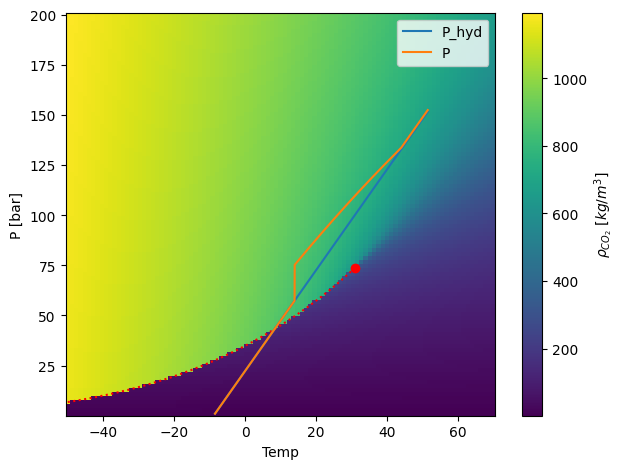

In [6]:
nx, ny = (101, 101)
T = np.linspace(-50, 70, nx)

P = np.linspace(1, 200, ny)
Tv, Pv = np.meshgrid(T, P)



Tv = Tv.flatten()
Pv = Pv.flatten()

density_coolprop = PropsSI("D", "P", Pv*1e5, "T", Tv+273.15, "CO2")



Pcrit = PropsSI('CO2', 'pcrit')
Tcrit = PropsSI('CO2', 'Tcrit')

Tphase = np.linspace(273.15-50, Tcrit, 2000)
Pphase = PropsSI('P','T',Tphase,'Q',0,'CO2')

Tv = Tv.reshape(nx, ny)
Pv = Pv.reshape(nx, ny)
density_coolprop = density_coolprop.reshape(nx, ny)

fig, ax = plt.subplots()

pcm = ax.pcolormesh(Tv, Pv, density_coolprop, shading='nearest')

ax.scatter(Tcrit-273.15, Pcrit/1e5, c='red', label='critical P,T')
ax.plot(Tphase-273.15, Pphase/1e5, c='red', ls=':')
ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('P [bar]')

df.plot(x='Temp', y='P_hyd', ax=ax)
df.plot(x='Temp', y='P', ax=ax)

fig.colorbar(pcm, label = r'$\rho_{CO_2}$ [$kg/m^3$]')

fig.tight_layout()

# fig.savefig('CO2_density.png')


In [ ]:
nx, ny = (101, 101)
T = np.linspace(-50, 70, nx)

P = np.linspace(1, 200, ny)
Tv, Pv = np.meshgrid(T, P)



Tv = Tv.flatten()
Pv = Pv.flatten()

# fluid = 'HEOS::CO2[0.98]&Ar[0.02]'
fluid = 'HEOS::CO2[0.96]&H2[0.004]&Ar[0.01]&N2[0.0084]&CH4[0.0178]'


density_coolprop = PropsSI("D", "P", Pv*1e5, "T", Tv+273.15, fluid)



# Pcrit = PropsSI(fluid, 'pcrit')
# Tcrit = PropsSI(fluid, 'Tcrit')

# Tphase = np.linspace(273.15-50, Tcrit, 2000)
# Pphase = PropsSI('P','T',Tphase,'Q',0,fluid)

Tv = Tv.reshape(nx, ny)
Pv = Pv.reshape(nx, ny)
# density_coolprop = density_coolprop.reshape(nx, ny)

fig, ax = plt.subplots()

# pcm = ax.pcolormesh(Tv, Pv, density_coolprop, shading='nearest')

ax.scatter(Tcrit-273.15, Pcrit/1e5, c='red', label='critical P,T')
ax.plot(Tphase-273.15, Pphase/1e5, c='red', ls=':')
ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('P [bar]')


fig.colorbar(pcm, label = r'$\rho_{CO_2}$ [$kg/m^3$]')

fig.tight_layout()

# fig.savefig('CO2_density.png')


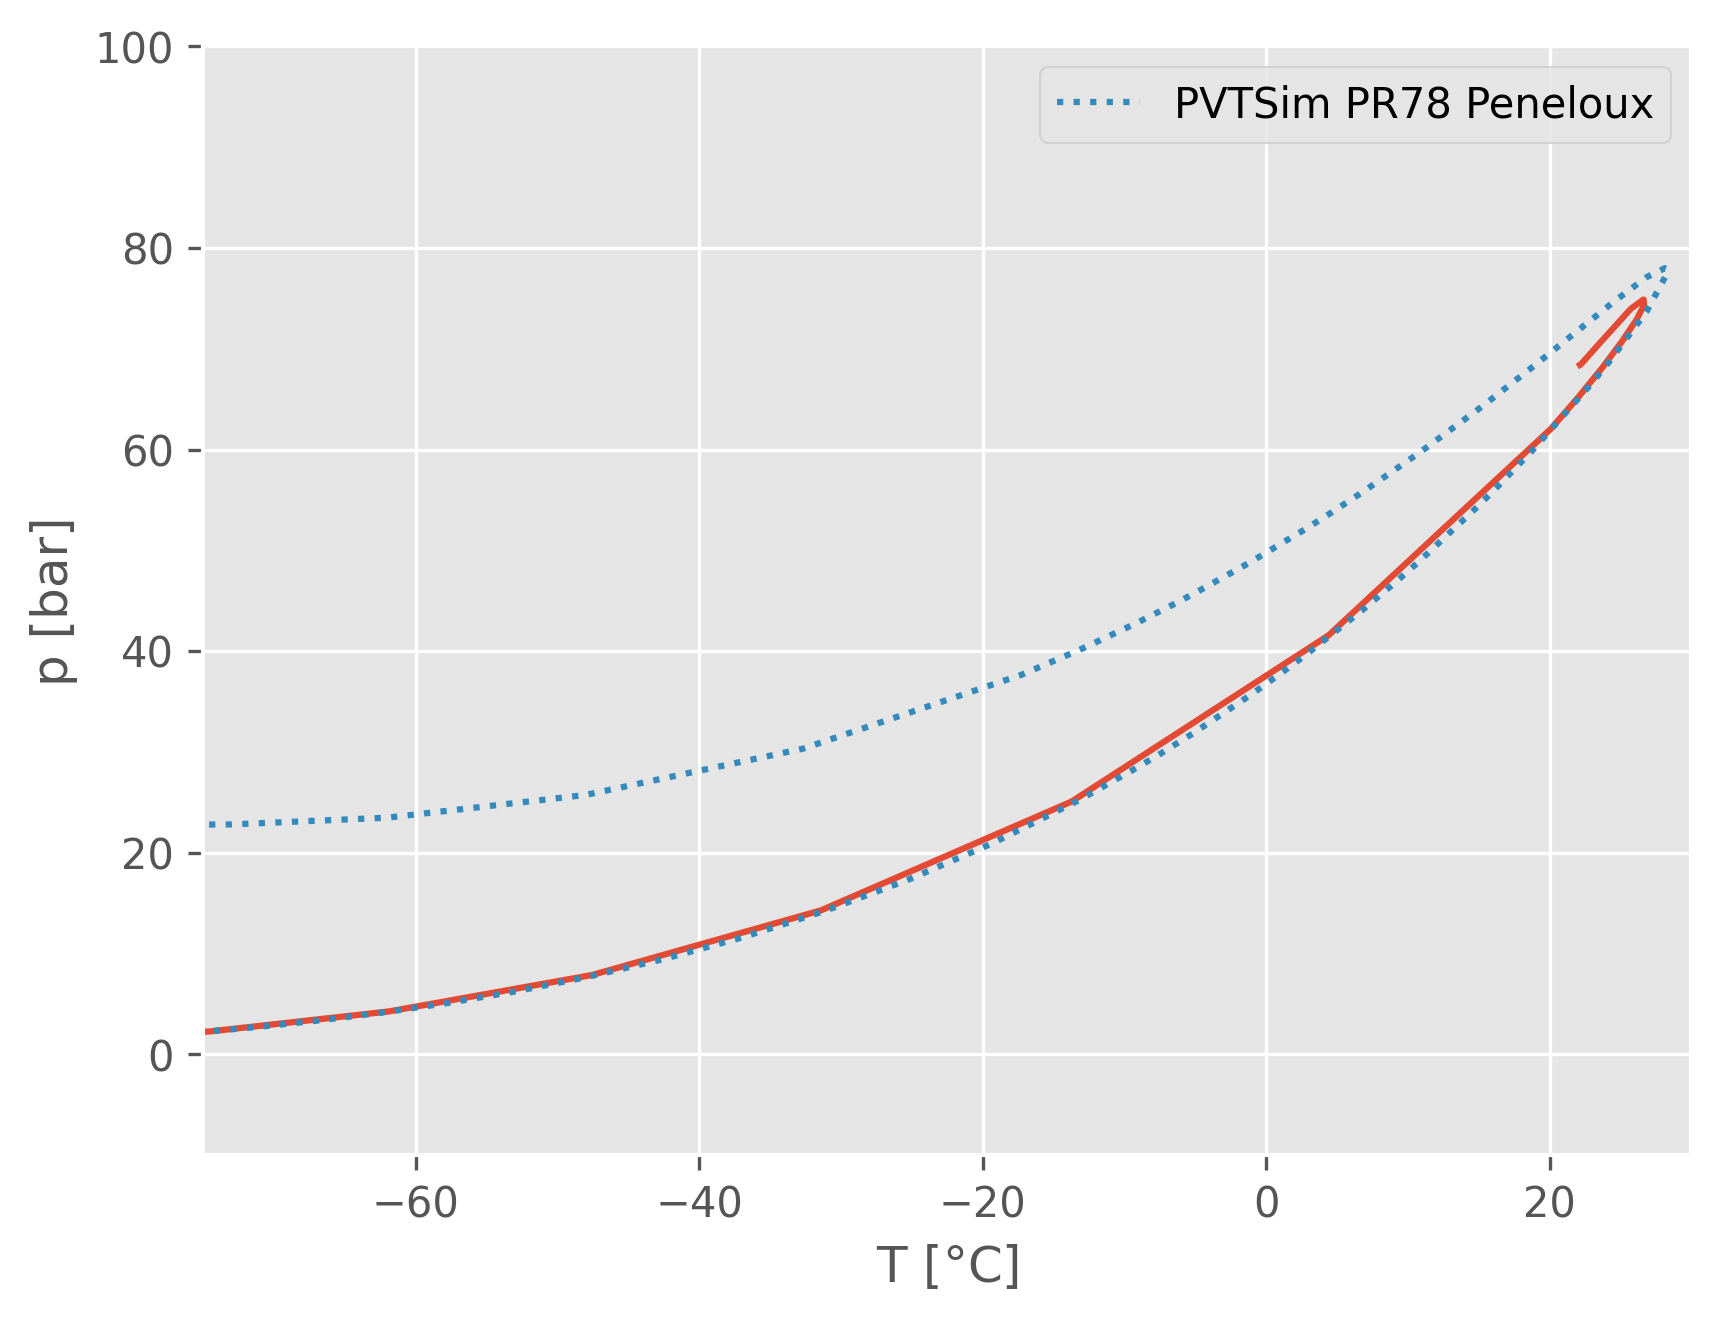

In [27]:
import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

plt.style.use('ggplot')

HEOS = CP.AbstractState('HEOS', 'CO2&H2&Ar&N2&CH4')
HEOS.set_mole_fractions([0.96, 0.004, 0.01, 0.0084, 0.0178])

HEOS.build_phase_envelope("dummy")
PE = HEOS.get_phase_envelope_data()

PE_T = np.array(PE.T)-273.15
PE_p = np.array(PE.p)/1e5

PVTSim_T = [-140.340,-138.719,-137.052,-135.339,-133.576,-131.761,-129.892,-127.965,-125.979,-123.930,-121.815,-119.630,-117.373,-115.038,-112.621,-110.119,-107.526,-104.837,-102.046,-99.148,-96.135,-93.001,-89.739,-86.339,-82.795,-79.095,-75.231,-71.192,-66.966,-62.540,-57.902,-53.039,-47.934,-42.573,-36.941,-31.172,-25.297,-19.354,-13.394,-13.150,-9.150,-7.479,-5.150,-1.150,1.139,2.850,6.850,9.172,10.850,14.850,16.258,18.850,22.850,24.273,26.850,28.329,28.333,28.284,28.128,26.850,24.610,22.850,18.850,15.684,14.850,10.850,6.850,4.729,2.850,-1.150,-5.150,-6.505,-9.150,-13.150,-17.255,-32.715,-48.043,-62.005,-73.024,-75.806,-84.419,-96.327,-108.831,-122.010,-131.639,-139.147,-145.402,-151.192,-155.728,-159.474,-162.046,-162.320,-162.492,-162.610,-162.620,-162.620]

PVTSim_P = [0.010,0.012,0.015,0.019,0.023,0.028,0.035,0.043,0.053,0.065,0.080,0.098,0.121,0.149,0.183,0.225,0.277,0.341,0.419,0.516,0.635,0.782,0.962,1.184,1.457,1.793,2.207,2.716,3.343,4.114,5.063,6.231,7.668,9.437,11.615,14.219,17.304,20.916,25.084,25.267,28.417,29.818,31.858,35.611,37.908,39.699,44.147,46.905,48.985,54.256,56.224,60.018,66.382,68.837,73.718,77.583,77.681,77.916,77.997,77.109,74.753,72.771,68.249,64.771,63.876,59.726,55.828,53.865,52.187,48.802,45.673,44.668,42.788,40.141,37.664,30.318,25.731,23.482,22.812,22.785,23.055,24.343,27.075,32.281,38.726,46.553,56.334,69.991,86.149,106.037,126.076,128.755,130.533,131.816,131.924,131.924]



fig, ax = plt.subplots()
ax.plot(PE_T, PE_p, '-')
ax.plot(PVTSim_T, PVTSim_P, ':', label = 'PVTSim PR78 Peneloux')

# for x0 in [0.02, 0.2, 0.4, 0.6, 0.8, 0.98]:
#     HEOS.set_mole_fractions([x0, 1 - x0])
#     try:
#         HEOS.build_phase_envelope("dummy")
#         PE = HEOS.get_phase_envelope_data()
#         PELabel = 'Methane, x = ' + str(x0)
#         plt.plot(PE.T, PE.p, '-', label=PELabel)
#     except ValueError as VE:
#         print(VE)

# plt.xlabel('Temperature [K]')
# plt.ylabel('Pressure [Pa]')
# plt.yscale('log')
# plt.title('Phase Envelope for Methane/Ethane Mixtures')
# plt.legend(loc='lower right', shadow=True)
# plt.savefig('methane-ethane.pdf')
# plt.savefig('methane-ethane.png')
# plt.close()

# df.plot(x='Temp', y='P_hyd', ax=ax)
# df.plot(x='Temp', y='P', ax=ax)

ax.set_xlabel('T [$\degree$C]')
ax.set_ylabel('p [bar]')
ax.set_xlim(-75, 30)
ax.set_ylim(-10, 100)
ax.legend()
fig.savefig('phase_envelope.png')

In [6]:
HEOS.get_phase_envelope_data()

In [26]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#E5E5E5',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'both',
    

In [ ]:
HEOS.

In [9]:
PE.T

[120.09100969105518,
 120.37959073869733,
 120.66985113856008,
 120.96180724565261,
 121.2554756371356,
 121.83415199505076,
 122.95996993304243,
 125.10545425038411,
 129.08151116268948,
 133.38135029395337,
 138.0510813319848,
 143.14619010594294,
 148.73387567367436,
 154.8959651943494,
 161.73245339396775,
 169.3655748583068,
 177.94396226687644,
 187.6456115134773,
 198.67651862634693,
 211.25785547615556,
 225.5861733211943,
 241.733798441795,
 259.4234772608849,
 277.5483785967386,
 293.2231939890786,
 295.1750942688165,
 296.86909038750935,
 298.25585203535405,
 299.27036268365373,
 299.81957874956356,
 299.7865104808169,
 299.7607628289652,
 298.87945423173585,
 296.5955568679832,
 295.3480574218551,
 295.3296140424173,
 295.292715101243]